# Figures

###################################################
arrival f1: 0.566 (0.554, 0.579)
arrival precision: 0.395 (0.383, 0.407)
arrival accuracy: 0.395 (0.383, 0.407)
###################################################
codes f1: 0.418 (0.402, 0.433)
codes precision: 0.382 (0.365, 0.399)
codes accuracy: 0.492 (0.479, 0.503)
###################################################
medrecon f1: 0.567 (0.554, 0.579)
medrecon precision: 0.395 (0.383, 0.408)
medrecon accuracy: 0.396 (0.383, 0.408)
###################################################
pyxis f1: 0.564 (0.551, 0.577)
pyxis precision: 0.394 (0.382, 0.407)
pyxis accuracy: 0.395 (0.384, 0.408)
###################################################
triage f1: 0.566 (0.554, 0.579)
triage precision: 0.395 (0.383, 0.408)
triage accuracy: 0.395 (0.383, 0.408)
###################################################
vitals f1: 0.566 (0.554, 0.579)
vitals precision: 0.395 (0.383, 0.407)
vitals accuracy: 0.395 (0.383, 0.407)
###############################

Text(0, 0.5, 'Precision (PPV)')

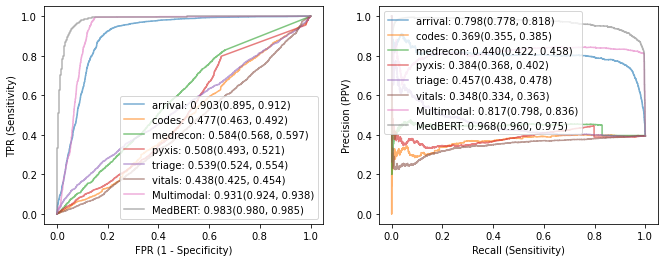

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, precision_score, recall_score
import numpy as np 

arrival_txt_df = pd.read_csv('../models/data/Finetune-arrival.csv')
codes_txt_df = pd.read_csv('../models/data/Finetune-codes.csv')
medrecon_txt_df = pd.read_csv('../models/data/Finetune-medrecon.csv')
pyxis_txt_df = pd.read_csv('../models/data/Finetune-pyxis.csv')
triage_txt_df = pd.read_csv('../models/data/Finetune-triage.csv')
vitals_txt_df = pd.read_csv('../models/data/Finetune-vitals.csv')
fusion_txt_df = pd.read_csv('../models/data/Finetune-multimodal.csv')
medbert_df = pd.read_csv('../models/data/Finetune-multimodal-medbert.csv')

result_dict = {
    "arrival": arrival_txt_df,
    "codes": codes_txt_df,
    "medrecon": medrecon_txt_df,
    "pyxis": pyxis_txt_df,
    "triage": triage_txt_df,
    "vitals": vitals_txt_df,
    "Multimodal": fusion_txt_df,
    "MedBERT": medbert_df
}

def bootstrap_scores(yt, yp, n=1000):
    aurocs, auprcs, f1s, precision, accuracy = [], [], [], [], []
    preds = (yp > 0.5).astype(int)
    for i in range(n):
        idx = np.random.choice(len(yt), len(yt), replace=True)
        aurocs.append(roc_auc_score(yt[idx], yp[idx]))
        auprcs.append(average_precision_score(yt[idx], yp[idx]))
        f1s.append(f1_score(yt[idx], preds[idx]))
        accuracy.append(accuracy_score(yt[idx], preds[idx]))
        precision.append(precision_score(yt[idx], preds[idx]))
        
    return {
        'auroc': (np.percentile(aurocs, 2.5), np.percentile(aurocs, 97.5)),
        'auprc': (np.percentile(auprcs, 2.5), np.percentile(auprcs, 97.5)),
        'f1': (np.percentile(f1s, 2.5), np.percentile(f1s, 97.5)),
        'precision': (np.percentile(precision, 2.5), np.percentile(precision, 97.5)),
        'accuracy': (np.percentile(accuracy, 2.5), np.percentile(accuracy, 97.5))
    }

f, axarr = plt.subplots(1, 2, figsize=(11, 4))
for model_name, df in result_dict.items():
    yt = df['y_true']
    yp = df['y_prob']
    fpr, tpr, _ = roc_curve(yt, yp)
    precisions, recalls, _ = precision_recall_curve(yt, yp)
    auroc = roc_auc_score(yt, yp)
    auprc = average_precision_score(yt, yp)
    preds = (yp >= 0.5).astype(int)
    f1 = f1_score(yt, preds)
    accuracy = accuracy_score(yt, preds)
    precision = precision_score(yt, preds)
    recall = recall_score(yt, preds)

    bootstraps = bootstrap_scores(yt, yp, n=1000)
    print("###################################################")
    print(f"{model_name} f1: {f1:.3f} ({bootstraps['f1'][0]:.3f}, {bootstraps['f1'][1]:.3f})")
    print(f"{model_name} precision: {precision:.3f} ({bootstraps['precision'][0]:.3f}, {bootstraps['precision'][1]:.3f})")
    print(f"{model_name} accuracy: {accuracy:.3f} ({bootstraps['accuracy'][0]:.3f}, {bootstraps['accuracy'][1]:.3f})")  
    axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}({bootstraps["auroc"][0]:.3f}, {bootstraps["auroc"][1]:.3f})')
    axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}({bootstraps["auprc"][0]:.3f}, {bootstraps["auprc"][1]:.3f})')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')